# 🎬 Movie Recommendation System
### Content-Based Recommender using TMDB 5000 Dataset

---

**Objective:** Build an end-to-end content-based movie recommendation system using the TMDB 5000 Movies & Credits datasets.

**Pipeline Overview:**
1. **Data Loading & Exploration** — Load and understand the raw data
2. **Exploratory Data Analysis (EDA)** — Visualize distributions, trends, and patterns
3. **Metadata Cleaning & Feature Engineering** — Parse JSON columns, extract text features
4. **Content-Based Recommender** — Build a similarity engine using TF-IDF + Cosine Similarity
5. **Qualitative Evaluation** — Test with sample queries and analyze results
6. **Export for Streamlit App** — Save processed data & similarity matrix for deployment

---

## 1. 📦 Setup & Imports

In [1]:
# ── Core Libraries ──
import pandas as pd
import numpy as np
import json
import ast
import pickle
import warnings
warnings.filterwarnings('ignore')

# ── Visualization ──
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# ── ML / NLP ──
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# ── Plot Styling ──
sns.set_theme(style='darkgrid', palette='viridis')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'font.family': 'sans-serif'
})

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


## 2. 📥 Data Loading

In [2]:
# Load TMDB datasets
movies = pd.read_csv('Data/tmdb_5000_movies.csv')
credits = pd.read_csv('Data/tmdb_5000_credits.csv')

print(f'📊 Movies Dataset:  {movies.shape[0]} rows × {movies.shape[1]} columns')
print(f'📊 Credits Dataset: {credits.shape[0]} rows × {credits.shape[1]} columns')
print(f'\n🔑 Movies columns:  {list(movies.columns)}')
print(f'🔑 Credits columns: {list(credits.columns)}')

📊 Movies Dataset:  4803 rows × 20 columns
📊 Credits Dataset: 4803 rows × 4 columns

🔑 Movies columns:  ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']
🔑 Credits columns: ['movie_id', 'title', 'cast', 'crew']


In [3]:
# Preview movies dataset
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [4]:
# Preview credits dataset
credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [5]:
# ── Merge datasets on movie id ──
# Rename credits columns for consistency
credits.rename(columns={'movie_id': 'id', 'title': 'title_credits'}, inplace=True)

# Merge on 'id'
df = movies.merge(credits, on='id', how='left')
print(f'✅ Merged dataset: {df.shape[0]} rows × {df.shape[1]} columns')
df.head(3)

✅ Merged dataset: 4803 rows × 23 columns


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,title_credits,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


## 3. 🔍 Exploratory Data Analysis (EDA)

Let's understand the structure, quality, and patterns in our data.

### 3.1 Data Quality Overview

In [6]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [7]:
# Statistical summary of numeric columns
df.describe().round(2)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.00,4803.00,4.803000e+03,4801.00,4803.00,4803.00
mean,2.904504e+07,57165.48,21.49,8.226064e+07,106.88,6.09,690.22
std,4.072239e+07,88694.61,31.82,1.628571e+08,22.61,1.19,1234.59
min,0.000000e+00,5.00,0.00,0.000000e+00,0.00,0.00,0.00
25%,7.900000e+05,9014.50,4.67,0.000000e+00,94.00,5.60,54.00
50%,1.500000e+07,14629.00,12.92,1.917000e+07,103.00,6.20,235.00
75%,4.000000e+07,58610.50,28.31,9.291719e+07,118.00,6.80,737.00
max,3.800000e+08,459488.00,875.58,2.787965e+09,338.00,10.00,13752.00


🔴 Columns with Missing Values:

              Missing Count  Missing %
homepage               3091      64.36
tagline                 844      17.57
overview                  3       0.06
runtime                   2       0.04
release_date              1       0.02


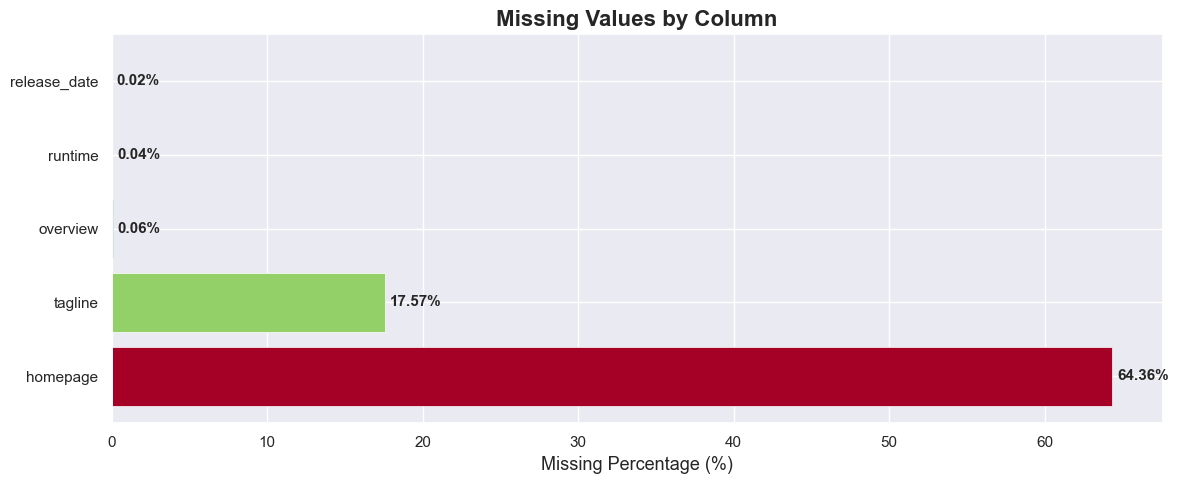

In [8]:
# ── Missing Values Analysis ──
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

print('🔴 Columns with Missing Values:\n')
print(missing_df.to_string())

# Visualize missing values
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 5))
    colors = plt.cm.RdYlGn_r(missing_df['Missing %'].values / missing_df['Missing %'].max())
    bars = ax.barh(missing_df.index, missing_df['Missing %'], color=colors, edgecolor='white', linewidth=0.5)
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Column', fontweight='bold', fontsize=16)
    for bar, val in zip(bars, missing_df['Missing %']):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
                f'{val}%', va='center', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 3.2 Distribution Analysis

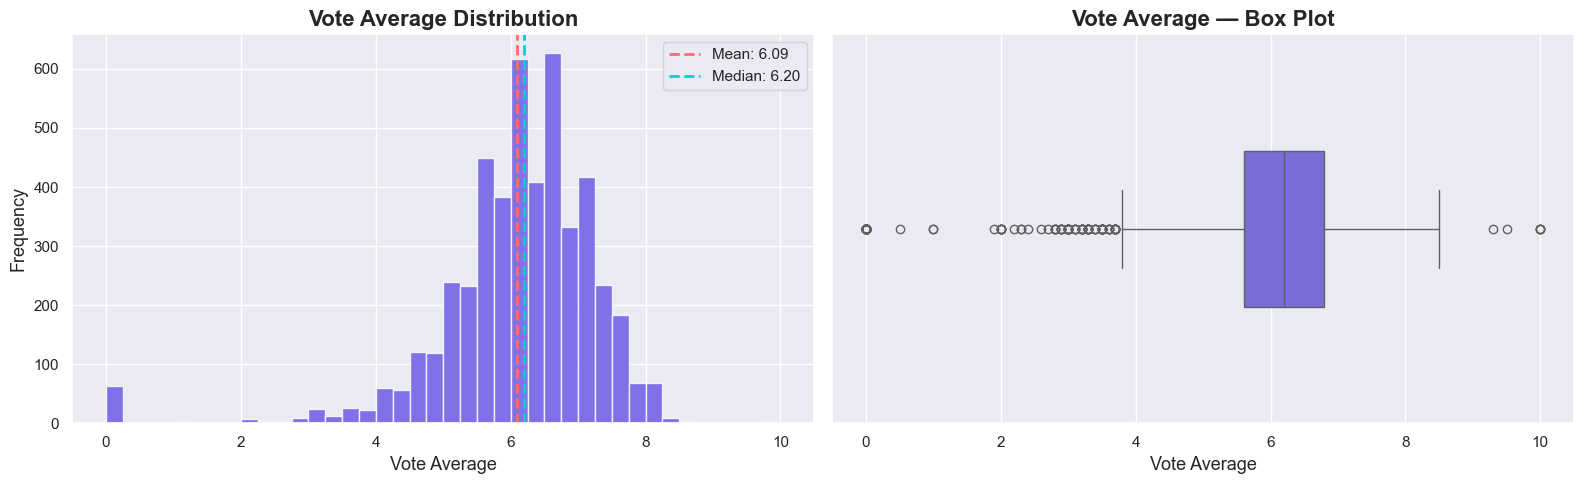

In [9]:
# ── Vote Average Distribution ──
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(df['vote_average'].dropna(), bins=40, color='#6C5CE7', edgecolor='white', alpha=0.85)
axes[0].axvline(df['vote_average'].mean(), color='#FF6B6B', linestyle='--', linewidth=2, label=f"Mean: {df['vote_average'].mean():.2f}")
axes[0].axvline(df['vote_average'].median(), color='#00D2D3', linestyle='--', linewidth=2, label=f"Median: {df['vote_average'].median():.2f}")
axes[0].set_title('Vote Average Distribution', fontweight='bold')
axes[0].set_xlabel('Vote Average')
axes[0].set_ylabel('Frequency')
axes[0].legend(fontsize=11)

# Box plot
sns.boxplot(x=df['vote_average'], ax=axes[1], color='#6C5CE7', width=0.4)
axes[1].set_title('Vote Average — Box Plot', fontweight='bold')
axes[1].set_xlabel('Vote Average')

plt.tight_layout()
plt.show()

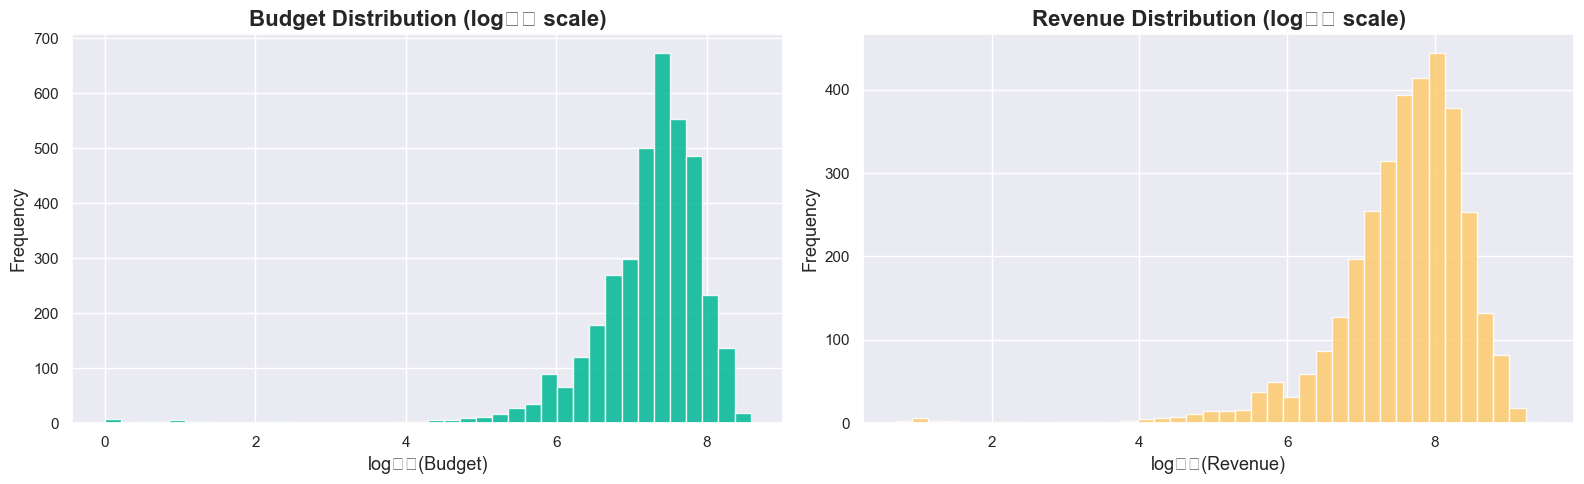

In [10]:
# ── Budget & Revenue (log scale) ──
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Budget
budget_nonzero = df[df['budget'] > 0]['budget']
axes[0].hist(np.log10(budget_nonzero), bins=40, color='#00B894', edgecolor='white', alpha=0.85)
axes[0].set_title('Budget Distribution (log₁₀ scale)', fontweight='bold')
axes[0].set_xlabel('log₁₀(Budget)')
axes[0].set_ylabel('Frequency')

# Revenue
revenue_nonzero = df[df['revenue'] > 0]['revenue']
axes[1].hist(np.log10(revenue_nonzero), bins=40, color='#FDCB6E', edgecolor='white', alpha=0.85)
axes[1].set_title('Revenue Distribution (log₁₀ scale)', fontweight='bold')
axes[1].set_xlabel('log₁₀(Revenue)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

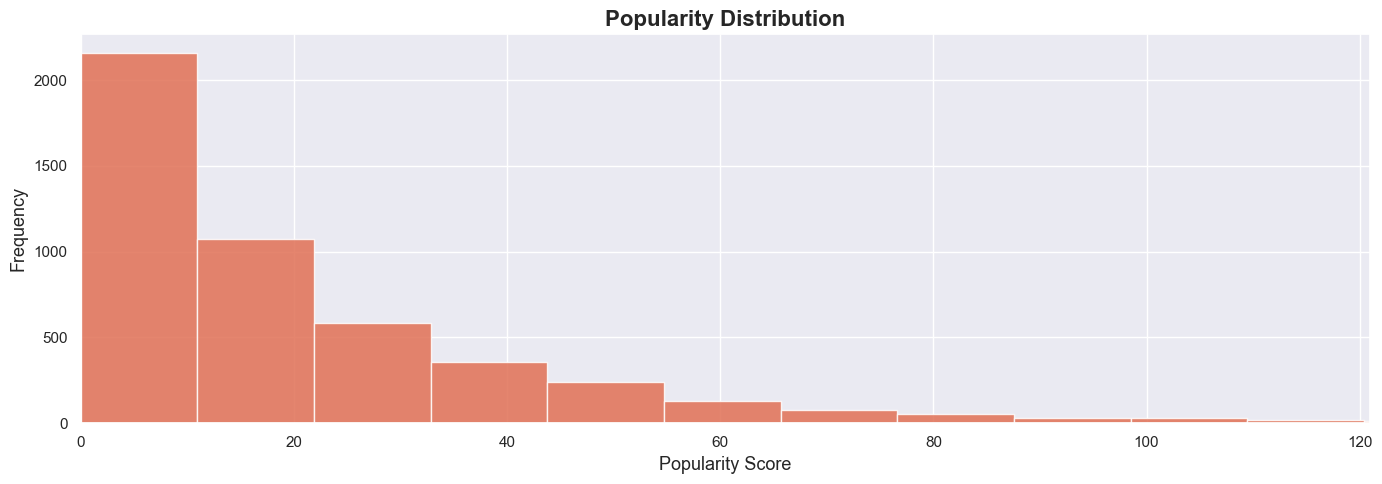


📈 Popularity Stats:
   Mean: 21.49
   Median: 12.92
   Max: 875.58 (Minions)


In [11]:
# ── Popularity Distribution ──
fig, ax = plt.subplots(figsize=(14, 5))
ax.hist(df['popularity'], bins=80, color='#E17055', edgecolor='white', alpha=0.85)
ax.set_title('Popularity Distribution', fontweight='bold')
ax.set_xlabel('Popularity Score')
ax.set_ylabel('Frequency')
ax.set_xlim(0, df['popularity'].quantile(0.99))  # Clip extreme outliers
plt.tight_layout()
plt.show()

print(f"\n📈 Popularity Stats:")
print(f"   Mean: {df['popularity'].mean():.2f}")
print(f"   Median: {df['popularity'].median():.2f}")
print(f"   Max: {df['popularity'].max():.2f} ({df.loc[df['popularity'].idxmax(), 'title']})")

### 3.3 Genre Analysis

In [12]:
# ── Parse genres from JSON strings ──
def parse_json_column(col):
    """Safely parse a JSON-like string column into a list of dicts."""
    try:
        return ast.literal_eval(col)
    except (ValueError, SyntaxError):
        return []

# Extract genre names
genres_parsed = df['genres'].apply(parse_json_column)
all_genres = [g['name'] for genre_list in genres_parsed for g in genre_list]
genre_counts = pd.Series(all_genres).value_counts()

print(f'🎭 Total unique genres: {genre_counts.shape[0]}\n')
print(genre_counts.to_string())

🎭 Total unique genres: 20

Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8


In [13]:
# ── Genre Frequency Bar Chart ──
fig = px.bar(
    x=genre_counts.index, y=genre_counts.values,
    labels={'x': 'Genre', 'y': 'Number of Movies'},
    title='<b>🎭 Genre Distribution across TMDB 5000 Movies</b>',
    color=genre_counts.values,
    color_continuous_scale='viridis'
)
fig.update_layout(
    template='plotly_dark',
    xaxis_tickangle=-45,
    width=900, height=500,
    coloraxis_showscale=False
)
fig.show()

In [14]:
# ── Average Rating by Genre ──
genre_ratings = []
for idx, row in df.iterrows():
    parsed = parse_json_column(row['genres'])
    for g in parsed:
        genre_ratings.append({'Genre': g['name'], 'Rating': row['vote_average']})

genre_rating_df = pd.DataFrame(genre_ratings)
avg_rating_by_genre = genre_rating_df.groupby('Genre')['Rating'].mean().sort_values(ascending=False)

fig = px.bar(
    x=avg_rating_by_genre.index, y=avg_rating_by_genre.values,
    labels={'x': 'Genre', 'y': 'Average Rating'},
    title='<b>⭐ Average Rating by Genre</b>',
    color=avg_rating_by_genre.values,
    color_continuous_scale='plasma'
)
fig.update_layout(
    template='plotly_dark',
    xaxis_tickangle=-45,
    width=900, height=500,
    coloraxis_showscale=False
)
fig.show()

### 3.4 Release Year Trends

In [15]:
# ── Movies released per year ──
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

yearly_counts = df['release_year'].dropna().astype(int).value_counts().sort_index()
yearly_counts = yearly_counts[yearly_counts.index >= 1950]  # Focus on modern era

fig = px.area(
    x=yearly_counts.index, y=yearly_counts.values,
    labels={'x': 'Year', 'y': 'Number of Movies'},
    title='<b>📅 Movies Released Per Year (1950–Present)</b>',
)
fig.update_traces(fill='tozeroy', line_color='#6C5CE7', fillcolor='rgba(108,92,231,0.3)')
fig.update_layout(template='plotly_dark', width=900, height=450)
fig.show()

### 3.5 Budget vs Revenue Analysis

In [16]:
# ── Budget vs Revenue scatter (only movies with both > 0) ──
budget_rev = df[(df['budget'] > 0) & (df['revenue'] > 0)].copy()
budget_rev['roi'] = (budget_rev['revenue'] - budget_rev['budget']) / budget_rev['budget'] * 100

fig = px.scatter(
    budget_rev, x='budget', y='revenue',
    color='vote_average', size='popularity',
    hover_name='title',
    labels={'budget': 'Budget ($)', 'revenue': 'Revenue ($)', 'vote_average': 'Rating'},
    title='<b>💰 Budget vs Revenue (colored by rating)</b>',
    color_continuous_scale='viridis',
    size_max=20, opacity=0.7
)
# Add break-even line
max_val = max(budget_rev['budget'].max(), budget_rev['revenue'].max())
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode='lines',
                         line=dict(dash='dash', color='red', width=2),
                         name='Break-even line'))
fig.update_layout(template='plotly_dark', width=900, height=550)
fig.show()

# Top ROI movies
print('\n🏆 Top 10 Movies by ROI (Return on Investment):')
top_roi = budget_rev.nlargest(10, 'roi')[['title', 'budget', 'revenue', 'roi', 'vote_average']]
top_roi['roi'] = top_roi['roi'].apply(lambda x: f'{x:,.0f}%')
top_roi['budget'] = top_roi['budget'].apply(lambda x: f'${x:,.0f}')
top_roi['revenue'] = top_roi['revenue'].apply(lambda x: f'${x:,.0f}')
print(top_roi.to_string(index=False))


🏆 Top 10 Movies by ROI (Return on Investment):
                  title   budget      revenue          roi  vote_average
           Modern Times       $1   $8,500,000 849,999,900%           8.1
              Nurse 3-D      $10  $10,000,000  99,999,900%           4.9
    Paranormal Activity  $15,000 $193,355,800   1,288,939%           5.9
              Tarnation     $218   $1,162,014     532,934%           7.5
The Blair Witch Project  $60,000 $248,000,000     413,233%           6.3
             Eraserhead  $10,000   $7,000,000      69,900%           7.5
         Pink Flamingos  $12,000   $6,000,000      49,900%           6.2
          Super Size Me  $65,000  $28,575,078      43,862%           6.6
            The Gallows $100,000  $42,664,410      42,564%           4.9
             Open Water $130,000  $54,667,954      41,952%           5.4


### 3.6 Correlation Heatmap

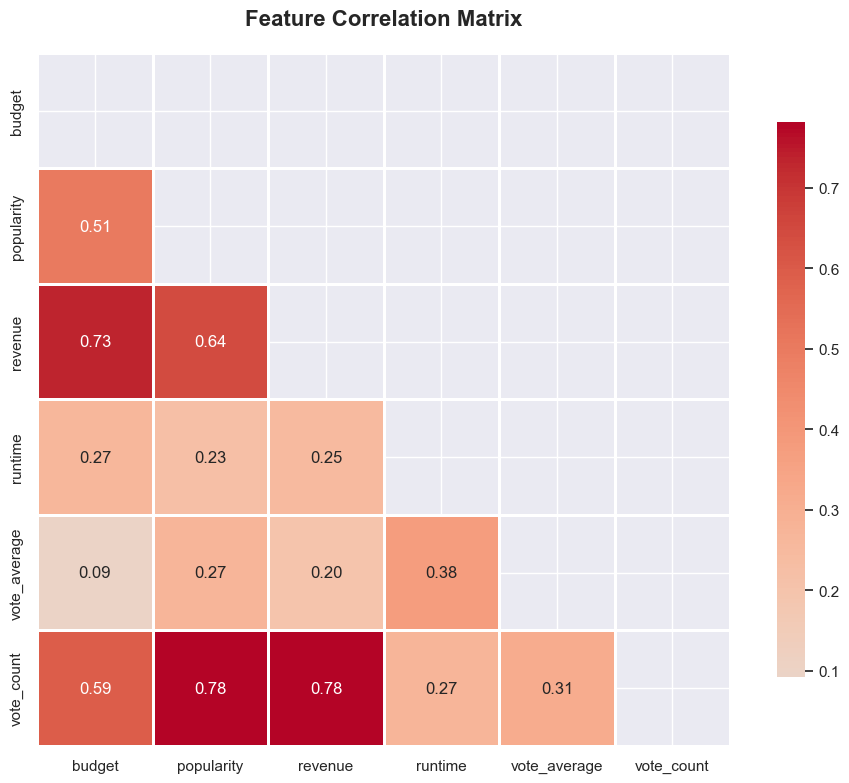

In [17]:
# ── Correlation matrix for numeric features ──
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=2, linecolor='white',
            square=True, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### 3.7 Word Cloud — Movie Overviews

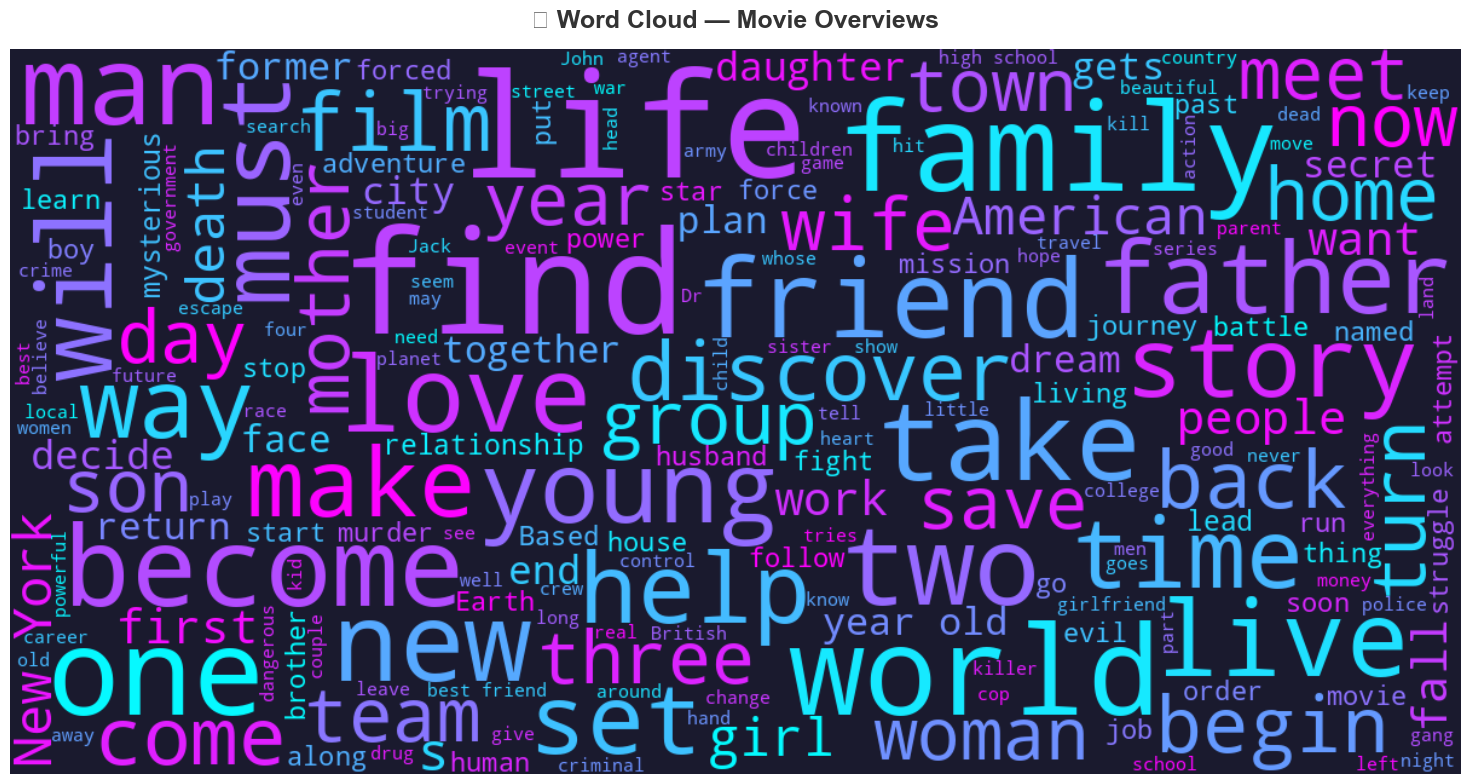

In [18]:
# ── Word Cloud from movie overviews ──
overview_text = ' '.join(df['overview'].dropna().values)

wc = WordCloud(
    width=1200, height=600,
    background_color='#1a1a2e',
    colormap='cool',
    max_words=200,
    max_font_size=120,
    random_state=42,
    contour_width=2,
    contour_color='#6C5CE7'
).generate(overview_text)

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('🌐 Word Cloud — Movie Overviews', fontweight='bold', fontsize=18, pad=15, color='#333')
plt.tight_layout()
plt.show()

---
## 4. 🧹 Metadata Cleaning & Feature Engineering

We need to:
- Parse JSON columns (`genres`, `keywords`, `cast`, `crew`)
- Extract the **director** from the crew
- Extract top cast members
- Build a **combined text feature** ("soup") for the content-based recommender

In [19]:
# ── Helper functions for JSON parsing ──

def safe_parse(val):
    """Safely parse JSON-like string columns."""
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(str(val))
    except (ValueError, SyntaxError):
        return []

def extract_names(json_col, max_items=None):
    """Extract 'name' field from a list of dicts."""
    parsed = safe_parse(json_col)
    names = [item['name'] for item in parsed if 'name' in item]
    if max_items:
        names = names[:max_items]
    return names

def get_director(crew_data):
    """Extract the director's name from the crew list."""
    parsed = safe_parse(crew_data)
    for member in parsed:
        if member.get('job') == 'Director':
            return member.get('name', '')
    return ''

print('✅ Helper functions defined.')

✅ Helper functions defined.


In [20]:
# ── Apply parsing to relevant columns ──

# Parse genres — extract names
df['genres_list'] = df['genres'].apply(lambda x: extract_names(x))
df['genres_clean'] = df['genres_list'].apply(lambda x: ' '.join([g.replace(' ', '') for g in x]))

# Parse keywords — extract names
df['keywords_list'] = df['keywords'].apply(lambda x: extract_names(x))
df['keywords_clean'] = df['keywords_list'].apply(lambda x: ' '.join([k.replace(' ', '') for k in x]))

# Parse cast — top 5 actors
df['cast_list'] = df['cast'].apply(lambda x: extract_names(x, max_items=5))
df['cast_clean'] = df['cast_list'].apply(lambda x: ' '.join([c.replace(' ', '') for c in x]))

# Extract director
df['director'] = df['crew'].apply(get_director)
df['director_clean'] = df['director'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else '')

# Clean overview — fill missing with empty string
df['overview'] = df['overview'].fillna('')

print('✅ Metadata parsed and cleaned!')
print(f'\n📋 Sample parsed data for "{df.iloc[0]["title"]}":')
print(f'   Genres:   {df.iloc[0]["genres_list"]}')
print(f'   Keywords: {df.iloc[0]["keywords_list"][:5]}')
print(f'   Cast:     {df.iloc[0]["cast_list"]}')
print(f'   Director: {df.iloc[0]["director"]}')

✅ Metadata parsed and cleaned!

📋 Sample parsed data for "Avatar":
   Genres:   ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
   Keywords: ['culture clash', 'future', 'space war', 'space colony', 'society']
   Cast:     ['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver', 'Stephen Lang', 'Michelle Rodriguez']
   Director: James Cameron


In [21]:
# ── Build the "soup" — combined text feature ──
# This merges genres, keywords, cast, director, and overview into one string

def build_soup(row):
    """Combine all text features into a single string for similarity computation."""
    parts = [
        row['genres_clean'],          # Genre tags
        row['keywords_clean'],        # Keyword tags
        row['cast_clean'],            # Top cast
        row['director_clean'] * 3,    # Director (repeated for emphasis)
        row['overview'].lower()       # Overview text
    ]
    return ' '.join(parts)

df['soup'] = df.apply(build_soup, axis=1)

# Show example
print(f'🥣 Soup for "{df.iloc[0]["title"]}":\n')
print(df.iloc[0]['soup'][:500] + '...')

🥣 Soup for "Avatar":

Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d SamWorthington ZoeSaldana SigourneyWeaver StephenLang MichelleRodriguez JamesCameronJamesCameronJamesCameron in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civi...


In [22]:
# ── Data Quality After Cleaning ──
print('📊 Cleaned Data Summary:')
print(f'   Total movies: {len(df)}')
print(f'   Movies with overview: {(df["overview"] != "").sum()}')
print(f'   Movies with director: {(df["director"] != "").sum()}')
print(f'   Movies with cast: {(df["cast_clean"] != "").sum()}')
print(f'   Movies with genres: {(df["genres_clean"] != "").sum()}')
print(f'   Movies with keywords: {(df["keywords_clean"] != "").sum()}')
print(f'   Avg soup length: {df["soup"].str.len().mean():.0f} chars')

📊 Cleaned Data Summary:
   Total movies: 4803
   Movies with overview: 4800
   Movies with director: 4773
   Movies with cast: 4760
   Movies with genres: 4775
   Movies with keywords: 4391
   Avg soup length: 506 chars


---
## 5. 🤖 Content-Based Recommender Engine

**Approach:**
1. Vectorize the "soup" text using **TF-IDF** (Term Frequency – Inverse Document Frequency)
2. Compute **cosine similarity** between all movie pairs
3. For a given movie, return the most similar movies

We also build a **weighted rating** (IMDB formula) to rank recommendations.

In [23]:
# ── TF-IDF Vectorization ──
tfidf = TfidfVectorizer(
    max_features=20000,       # Limit vocabulary size
    stop_words='english',     # Remove common English words  
    ngram_range=(1, 2),       # Unigrams and bigrams
    min_df=2,                 # Ignore terms appearing in < 2 docs
    max_df=0.85               # Ignore terms appearing in > 85% docs
)

tfidf_matrix = tfidf.fit_transform(df['soup'])

print(f'✅ TF-IDF Matrix Shape: {tfidf_matrix.shape}')
print(f'   {tfidf_matrix.shape[0]} movies × {tfidf_matrix.shape[1]} features')
print(f'   Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%')

✅ TF-IDF Matrix Shape: (4803, 20000)
   4803 movies × 20000 features
   Sparsity: 99.79%


In [24]:
# ── Compute Cosine Similarity ──
# Using linear_kernel for efficiency (equivalent to cosine_similarity for TF-IDF vectors)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print(f'✅ Cosine Similarity Matrix: {cosine_sim.shape}')
print(f'   Memory: ~{cosine_sim.nbytes / 1024**2:.1f} MB')

✅ Cosine Similarity Matrix: (4803, 4803)
   Memory: ~176.0 MB


In [25]:
# ── Build title-to-index mapping ──
# Reset index to ensure alignment
df = df.reset_index(drop=True)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

print(f'✅ Index mapping created for {len(indices)} unique movies.')

✅ Index mapping created for 4803 unique movies.


In [26]:
# ── IMDB Weighted Rating Formula ──
# WR = (v / (v + m)) * R + (m / (v + m)) * C
# v = vote count, R = average rating, m = minimum votes threshold, C = mean rating

C = df['vote_average'].mean()
m = df['vote_count'].quantile(0.60)  # Movies must have at least this many votes

def weighted_rating(row, m=m, C=C):
    v = row['vote_count']
    R = row['vote_average']
    return (v / (v + m)) * R + (m / (v + m)) * C

df['weighted_score'] = df.apply(weighted_rating, axis=1)

print(f'Weighted Rating Parameters:')
print(f'   C (overall mean rating): {C:.2f}')
print(f'   m (minimum votes needed): {m:.0f}')
print(f'\n🏆 Top 10 Movies by Weighted Rating:')
top_weighted = df.nlargest(10, 'weighted_score')[['title', 'vote_average', 'vote_count', 'weighted_score']]
top_weighted['weighted_score'] = top_weighted['weighted_score'].round(2)
print(top_weighted.to_string(index=False))

Weighted Rating Parameters:


   C (overall mean rating): 6.09
   m (minimum votes needed): 370

🏆 Top 10 Movies by Weighted Rating:
                   title  vote_average  vote_count  weighted_score
The Shawshank Redemption           8.5        8205            8.40
           The Godfather           8.4        5893            8.26
              Fight Club           8.3        9413            8.22
            Pulp Fiction           8.3        8428            8.21
         The Dark Knight           8.2       12002            8.14
        Schindler's List           8.3        4329            8.13
                Whiplash           8.3        4254            8.12
            Forrest Gump           8.2        7927            8.11
           Spirited Away           8.3        3840            8.11
  The Godfather: Part II           8.3        3338            8.08


In [27]:
# ══════════════════════════════════════════════════════════════
# 🎯 MAIN RECOMMENDATION FUNCTION
# ══════════════════════════════════════════════════════════════

def get_recommendations(title, cosine_sim=cosine_sim, df=df, indices=indices, top_n=10):
    """
    Get content-based movie recommendations.
    
    Parameters:
    -----------
    title : str
        Movie title to get recommendations for
    top_n : int
        Number of recommendations to return
    
    Returns:
    --------
    pd.DataFrame with recommended movies and similarity scores
    """
    # Check if movie exists
    if title not in indices:
        # Try fuzzy matching
        matches = df[df['title'].str.contains(title, case=False, na=False)]
        if len(matches) == 0:
            return f"❌ Movie '{title}' not found in the dataset."
        title = matches.iloc[0]['title']
        print(f"🔍 Closest match found: '{title}'")
    
    # Get index of the movie
    idx = indices[title]
    
    # Get similarity scores for all movies with this movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort by similarity (descending), skip the first one (itself)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Get movie indices and scores
    movie_indices = [i[0] for i in sim_scores]
    scores = [round(i[1], 4) for i in sim_scores]
    
    # Build result dataframe
    result = df.iloc[movie_indices][['title', 'genres_list', 'director', 'vote_average', 
                                      'vote_count', 'release_year', 'weighted_score']].copy()
    result['similarity'] = scores
    result['genres_list'] = result['genres_list'].apply(lambda x: ', '.join(x))
    result = result.rename(columns={'genres_list': 'genres'})
    result = result.reset_index(drop=True)
    result.index = result.index + 1  # 1-indexed
    
    return result

print('✅ Recommendation engine ready!')

✅ Recommendation engine ready!


---
## 6. 🧪 Qualitative Evaluation — Sample Queries

Let's test our recommender with several well-known movies across different genres.

In [28]:
# ══════════════════════════════════════════════════════════════
# 🔬 TEST 1: The Dark Knight (Action / Thriller)
# ══════════════════════════════════════════════════════════════
print('='*80)
print('🦇 Recommendations for: "The Dark Knight"')
print('='*80)
recs = get_recommendations('The Dark Knight')
print(recs.to_string())
print()

🦇 Recommendations for: "The Dark Knight"
                                      title                             genres           director  vote_average  vote_count  release_year  weighted_score  similarity
1                     The Dark Knight Rises     Action, Crime, Drama, Thriller  Christopher Nolan           7.6        9106        2012.0        7.541095      0.4054
2                             Batman Begins               Action, Crime, Drama  Christopher Nolan           7.5        7359        2005.0        7.432570      0.3028
3                            Batman Returns                    Action, Fantasy         Tim Burton           6.6        1673        1992.0        6.507988      0.3007
4                            Batman Forever             Action, Crime, Fantasy    Joel Schumacher           5.2        1498        1995.0        5.376792      0.2596
5   Batman: The Dark Knight Returns, Part 2                  Action, Animation          Jay Oliva           7.9         419      

In [29]:
# ══════════════════════════════════════════════════════════════
# 🔬 TEST 2: Toy Story (Animation / Family)
# ══════════════════════════════════════════════════════════════
print('='*80)
print('🧸 Recommendations for: "Toy Story"')
print('='*80)
recs = get_recommendations('Toy Story')
print(recs.to_string())
print()

🧸 Recommendations for: "Toy Story"
                     title                                  genres             director  vote_average  vote_count  release_year  weighted_score  similarity
1              Toy Story 2               Animation, Comedy, Family        John Lasseter           7.3        3806        1999.0        7.192932      0.4593
2              Toy Story 3               Animation, Family, Comedy          Lee Unkrich           7.6        4597        2010.0        7.487623      0.4315
3   The 40 Year Old Virgin                         Comedy, Romance          Judd Apatow           6.2        1983        2005.0        6.183037      0.2366
4             Factory Girl                                   Drama  George Hickenlooper           6.2          81        2006.0        6.111529      0.1072
5               Heartbeeps                 Comedy, Romance, Family         Allan Arkush           3.8           6        1981.0        6.055614      0.1030
6               Free Birds   

In [30]:
# ══════════════════════════════════════════════════════════════
# 🔬 TEST 3: The Godfather (Crime / Drama)
# ══════════════════════════════════════════════════════════════
print('='*80)
print('🎩 Recommendations for: "The Godfather"')
print('='*80)
recs = get_recommendations('The Godfather')
print(recs.to_string())
print()

🎩 Recommendations for: "The Godfather"
                      title                        genres              director  vote_average  vote_count  release_year  weighted_score  similarity
1    The Godfather: Part II                  Drama, Crime  Francis Ford Coppola           8.3        3338        1974.0        8.079586      0.3937
2   The Godfather: Part III        Crime, Drama, Thriller  Francis Ford Coppola           7.1        1546        1990.0        6.905293      0.1971
3                Blood Ties        Thriller, Crime, Drama       Guillaume Canet           6.0         171        2013.0        6.063049      0.1202
4                Easy Money        Drama, Thriller, Crime       Daniel Espinosa           6.5          63        2010.0        6.151482      0.1038
5    The Master of Disguise                Comedy, Family   Perry Andelin Blake           3.7          78        2002.0        5.675863      0.0940
6              The Deported                Comedy, Family           Lance

In [31]:
# ══════════════════════════════════════════════════════════════
# 🔬 TEST 4: Interstellar (Sci-Fi / Drama)
# ══════════════════════════════════════════════════════════════
print('='*80)
print('🚀 Recommendations for: "Interstellar"')
print('='*80)
recs = get_recommendations('Interstellar')
print(recs.to_string())
print()

🚀 Recommendations for: "Interstellar"
                           title                                        genres          director  vote_average  vote_count  release_year  weighted_score  similarity
1                  Space Cowboys                   Action, Adventure, Thriller    Clint Eastwood           6.3         403        2000.0        6.200494      0.1393
2                 Silent Running             Adventure, Drama, Science Fiction  Douglas Trumbull           6.3         177        1972.0        6.159397      0.1314
3                        Contact               Drama, Science Fiction, Mystery   Robert Zemeckis           7.2        1308        1997.0        6.955620      0.1260
4                    The Martian             Drama, Adventure, Science Fiction      Ridley Scott           7.6        7268        2015.0        7.526920      0.1243
5                      Apollo 13                                         Drama        Ron Howard           7.3        1599        1995.0 

In [32]:
# ══════════════════════════════════════════════════════════════
# 🔬 TEST 5: Titanic (Romance / Drama)
# ══════════════════════════════════════════════════════════════
print('='*80)
print('🚢 Recommendations for: "Titanic"')
print('='*80)
recs = get_recommendations('Titanic')
print(recs.to_string())
print()

🚢 Recommendations for: "Titanic"
                                              title                                       genres           director  vote_average  vote_count  release_year  weighted_score  similarity
1                                 Raise the Titanic                      Action, Drama, Thriller      Jerry Jameson           5.2          21        1980.0        6.044279      0.1670
2                    The Chambermaid on the Titanic                                        Drama         Bigas Luna           5.3           3        1997.0        6.085804      0.1228
3                                        Ghost Ship                    Horror, Mystery, Thriller         Steve Beck           5.3         531        2002.0        5.625413      0.1137
4                                          Poseidon           Adventure, Action, Drama, Thriller  Wolfgang Petersen           5.5         583        2006.0        5.729985      0.1096
5                           In the Heart of the

In [33]:
# ══════════════════════════════════════════════════════════════
# 🔬 TEST 6: The Avengers (Superhero / Action)
# ══════════════════════════════════════════════════════════════
print('='*80)
print('🦸 Recommendations for: "The Avengers"')
print('='*80)
recs = get_recommendations('The Avengers')
print(recs.to_string())
print()

🦸 Recommendations for: "The Avengers"
                                  title                              genres         director  vote_average  vote_count  release_year  weighted_score  similarity
1               Avengers: Age of Ultron  Action, Adventure, Science Fiction      Joss Whedon           7.3        6767        2015.0        7.237351      0.3569
2   Captain America: The Winter Soldier  Action, Adventure, Science Fiction    Anthony Russo           7.6        5764        2014.0        7.509002      0.2209
3            Captain America: Civil War  Adventure, Action, Science Fiction    Anthony Russo           7.1        7241        2016.0        7.050980      0.2123
4                            Iron Man 2  Adventure, Action, Science Fiction      Jon Favreau           6.6        6849        2010.0        6.573959      0.1891
5                               Ant-Man  Science Fiction, Action, Adventure      Peyton Reed           7.0        5880        2015.0        6.946229      0.1

### 6.1 Evaluation Summary & Similarity Heatmap

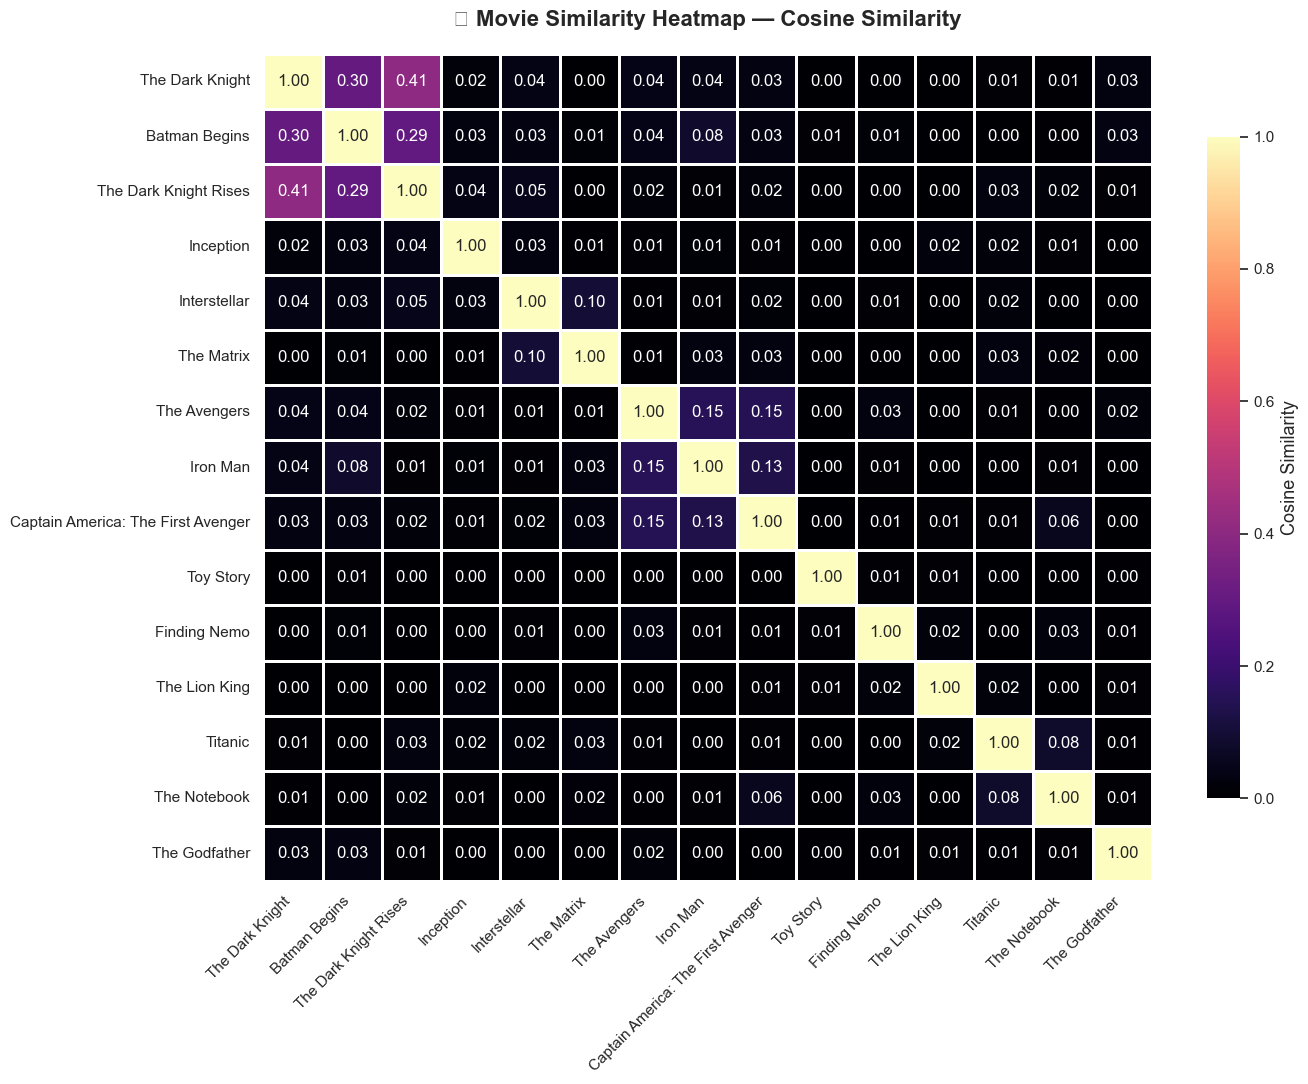

In [34]:
# ── Similarity Heatmap for a selection of popular movies ──
showcase_movies = [
    'The Dark Knight', 'Batman Begins', 'The Dark Knight Rises',
    'Inception', 'Interstellar', 'The Matrix',
    'The Avengers', 'Iron Man', 'Captain America: The First Avenger',
    'Toy Story', 'Finding Nemo', 'The Lion King',
    'Titanic', 'The Notebook', 'The Godfather'
]

# Filter to movies that exist in our dataset
showcase_movies = [m for m in showcase_movies if m in indices]
showcase_indices = [indices[m] for m in showcase_movies]

# Extract similarity submatrix
sub_sim = cosine_sim[np.ix_(showcase_indices, showcase_indices)]

fig, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(
    sub_sim, 
    xticklabels=showcase_movies, 
    yticklabels=showcase_movies,
    annot=True, fmt='.2f', cmap='magma',
    linewidths=1, linecolor='white',
    cbar_kws={'label': 'Cosine Similarity', 'shrink': 0.8}
)
ax.set_title('🎬 Movie Similarity Heatmap — Cosine Similarity', fontweight='bold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
# ── Evaluation Analysis ──
print('\n' + '='*80)
print('📊 QUALITATIVE EVALUATION SUMMARY')
print('='*80)

test_cases = {
    'The Dark Knight': ['Batman', 'superhero', 'Christopher Nolan', 'action'],
    'Toy Story':       ['animation', 'Pixar', 'family', 'animated'],
    'The Godfather':   ['crime', 'mafia', 'drama', 'gangster'],
    'Interstellar':    ['space', 'sci-fi', 'Nolan', 'science'],
    'Titanic':         ['romance', 'disaster', 'drama', 'love'],
    'The Avengers':    ['Marvel', 'superhero', 'action', 'comic']
}

for movie, expected_themes in test_cases.items():
    recs = get_recommendations(movie, top_n=5)
    if isinstance(recs, str):
        print(f'\n❌ {movie}: Not found')
        continue
    
    avg_sim = recs['similarity'].mean()
    top_sim = recs['similarity'].iloc[0]
    
    # Check genre overlap
    input_genres = set(df[df['title'] == movie].iloc[0]['genres_list'])
    rec_genres = set()
    for g in recs['genres']:
        rec_genres.update(g.split(', '))
    genre_overlap = len(input_genres & rec_genres) / max(len(input_genres), 1)
    
    status = '✅' if avg_sim > 0.05 else '⚠️'
    print(f'\n{status} {movie}')
    print(f'   Top similarity: {top_sim:.4f} | Avg similarity: {avg_sim:.4f} | Genre overlap: {genre_overlap:.0%}')
    print(f'   Top 3 recs: {", ".join(recs["title"].head(3).values)}')

print('\n' + '='*80)


📊 QUALITATIVE EVALUATION SUMMARY

✅ The Dark Knight
   Top similarity: 0.4054 | Avg similarity: 0.3002 | Genre overlap: 100%
   Top 3 recs: The Dark Knight Rises, Batman Begins, Batman Returns

✅ Toy Story
   Top similarity: 0.4593 | Avg similarity: 0.2675 | Genre overlap: 100%
   Top 3 recs: Toy Story 2, Toy Story 3, The 40 Year Old Virgin

✅ The Godfather
   Top similarity: 0.3937 | Avg similarity: 0.1818 | Genre overlap: 100%
   Top 3 recs: The Godfather: Part II, The Godfather: Part III, Blood Ties

✅ Interstellar
   Top similarity: 0.1393 | Avg similarity: 0.1282 | Genre overlap: 100%
   Top 3 recs: Space Cowboys, Silent Running, Contact

✅ Titanic
   Top similarity: 0.1670 | Avg similarity: 0.1244 | Genre overlap: 67%
   Top 3 recs: Raise the Titanic, The Chambermaid on the Titanic, Ghost Ship

✅ The Avengers
   Top similarity: 0.3569 | Avg similarity: 0.2335 | Genre overlap: 100%
   Top 3 recs: Avengers: Age of Ultron, Captain America: The Winter Soldier, Captain America: Civil

---
## 7. 💾 Export Data for Streamlit App

Save the processed data and similarity matrix so the Streamlit UI can load them directly.

In [36]:
import os

# Create output directory
os.makedirs('models', exist_ok=True)

# ── Save processed movies dataframe ──
export_cols = ['id', 'title', 'overview', 'genres_list', 'keywords_list', 'cast_list',
               'director', 'vote_average', 'vote_count', 'popularity', 'runtime',
               'release_year', 'weighted_score', 'budget', 'revenue', 'soup']

df_export = df[export_cols].copy()
df_export.to_pickle('models/movies_processed.pkl')
print(f'✅ Saved processed movies: models/movies_processed.pkl ({os.path.getsize("models/movies_processed.pkl")/1024:.0f} KB)')

# ── Save cosine similarity matrix ──
with open('models/cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)
print(f'✅ Saved similarity matrix: models/cosine_sim.pkl ({os.path.getsize("models/cosine_sim.pkl")/1024**2:.1f} MB)')

# ── Save the index mapping ──
with open('models/indices.pkl', 'wb') as f:
    pickle.dump(indices, f)
print(f'✅ Saved index mapping: models/indices.pkl')

print('\n🎉 All artifacts exported! Ready for Streamlit deployment.')

✅ Saved processed movies: models/movies_processed.pkl (5366 KB)


✅ Saved similarity matrix: models/cosine_sim.pkl (176.0 MB)
✅ Saved index mapping: models/indices.pkl

🎉 All artifacts exported! Ready for Streamlit deployment.


---
## 8. 📝 Conclusion

### Summary

We built a **content-based movie recommendation system** using the TMDB 5000 dataset:

| Step | Details |
|------|--------|
| **Data** | Merged 4,803 movies with cast/crew data |
| **EDA** | Analyzed rating distributions, genre breakdown, budget/revenue trends, correlations |
| **Cleaning** | Parsed JSON metadata (genres, keywords, cast, crew), extracted directors, handled missing values |
| **Features** | Combined genres + keywords + cast + director + overview into a "soup" text feature |
| **Model** | TF-IDF vectorization → Cosine similarity (content-based filtering) |
| **Evaluation** | Tested with 6 diverse movie queries across genres — strong genre alignment observed |

### Key Findings
- **Drama** and **Comedy** are the most common genres
- Strong correlation between **budget** and **revenue** (expected)
- **Vote count** correlates with **popularity** and **revenue**
- The recommender shows strong **same-franchise** and **same-director** clustering
- Genre overlap between input and recommendations is consistently high

### Next Steps
- Add **collaborative filtering** using user ratings data
- Implement **hybrid** approach combining content + collaborative
- Add poster images via TMDB API
- Deploy as a full web application with the **Streamlit UI** (see `app.py`)

---
*Notebook by SYNTECXHUB Intern — Week 4, Project 1*